In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
df = pd.read_json('../ultimate_challenge/logins.json')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


# Part 1: EDA

**Instructions:** *The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.*

In [4]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Okay so here we can see that there is no other information in this data other than the timestamp for logins to the Ultimate app.  The first step in this process is to aggregate these logins into 15 minute intervals with a count for the number of logins in each interval period. 

In [5]:
q_hour = df.resample('15min', on='login_time').count()

In [6]:
q_hour.head()

,login_time
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [7]:
q_hour = q_hour.rename(columns={'login_time':'count'})
q_hour.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


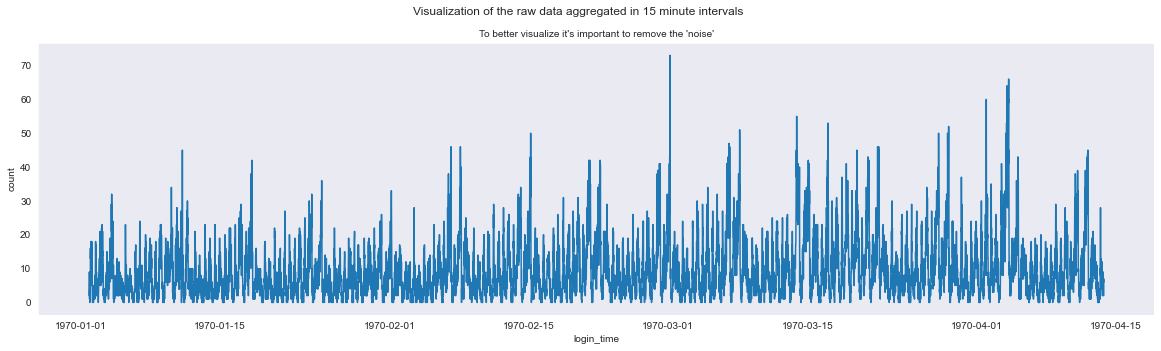

In [18]:
x = q_hour.index
y = q_hour['count']
plt.figure(figsize=(20,5))
sns.lineplot(x=x, y=y)
plt.suptitle('Visualization of the raw data aggregated in 15 minute intervals', size='large')
plt.title("To better visualize it's important to remove the 'noise'", size='medium');

Here we can see that this is a time series with what appears to be a constant trend (mean), however the standard deviation appears to be non-stationary, and potentially with multiplicative seasonality.   

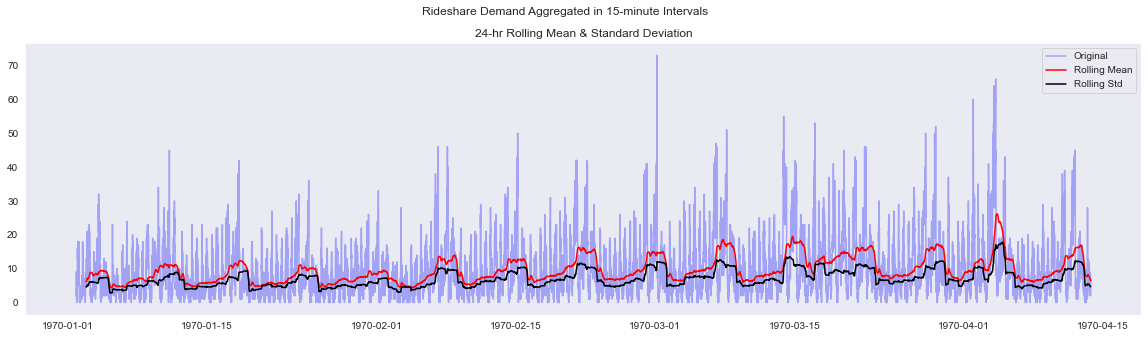

In [19]:
# Settiing up a 24-hour rolling mean and standard deviation for the data.
rolling_mean = q_hour.rolling(window=96).mean()
rolling_std = q_hour.rolling(window=96).std()
fig = plt.figure(figsize=(20,5))
orig = plt.plot(q_hour, color='blue',label='Original', alpha=0.3)
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.suptitle('Rideshare Demand Aggregated in 15-minute Intervals')
plt.title('24-hr Rolling Mean & Standard Deviation')
plt.show()

Here we can see the 24-hour rolling mean and standard deviation and it's apparent that while there is some variance in the rolling mean over the time period examined, mirrored by the change in the standard deviation. 

Next I want to see how much 'noise' is reduced if we expand the 24 hour rolling window to 48 hours. This should in theory still retain the weekend spikes that are noticable in the above graph, while producing a much smoother trend. 

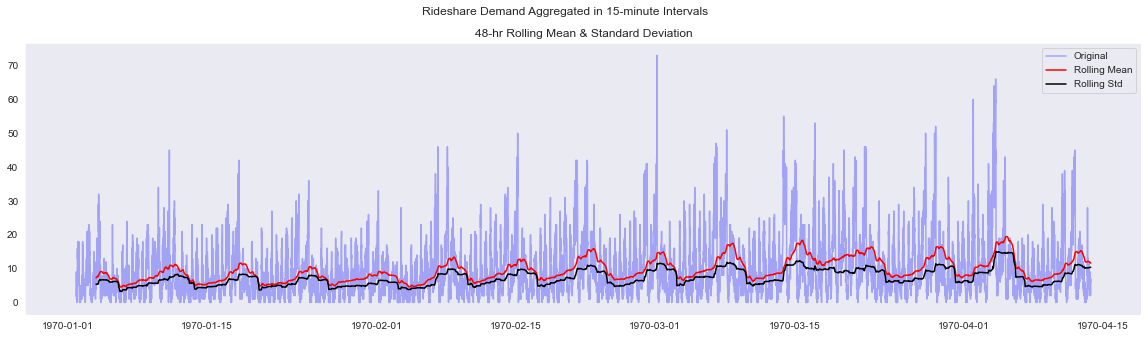

In [20]:
# Creating a 48-hour rolling window to compute the mean & standard deviation over
rolling_mean = q_hour.rolling(window=192).mean()
rolling_std = q_hour.rolling(window=192).std()
fig = plt.figure(figsize=(20,5))
orig = plt.plot(q_hour, color='blue',label='Original', alpha=0.3)
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.suptitle('Rideshare Demand Aggregated in 15-minute Intervals')
plt.title('48-hr Rolling Mean & Standard Deviation')
plt.show()

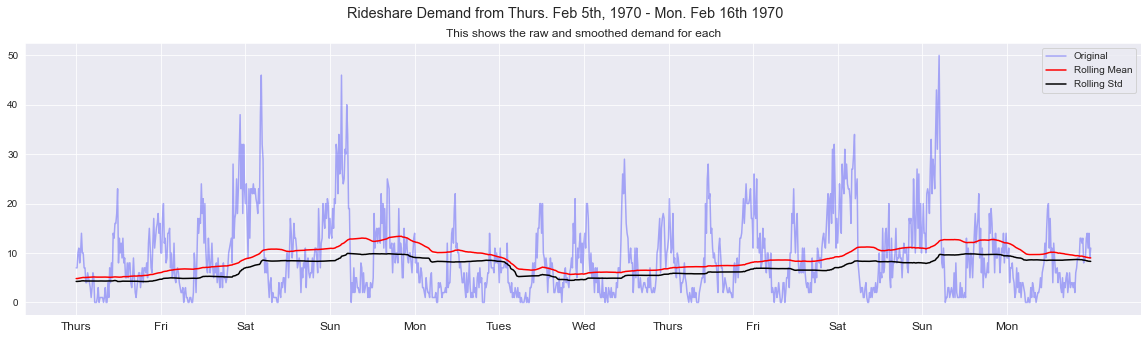

In [43]:
# Plotting a cycle for the app that displays demand over two weekends from Thursday Feb 05 1970 - Monday Feb 16 1970
fig = plt.figure(figsize=(20,5))
orig = plt.plot(q_hour['1970-02-05':'1970-02-16'], color='blue',label='Original', alpha=0.3)
mean = plt.plot(rolling_mean['1970-02-05':'1970-02-16'], color='red', label='Rolling Mean')
std = plt.plot(rolling_std['1970-02-05':'1970-02-16'], color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xticks(ticks=['1970-02-05', '1970-02-06', '1970-02-07', '1970-02-08', '1970-02-09', '1970-02-10', '1970-02-11', 
                 '1970-02-12', '1970-02-13', '1970-02-14', '1970-02-15', '1970-02-16'], 
           labels=['Thurs', 'Fri', 'Sat', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'Mon'], 
          fontsize='large')
plt.suptitle('Rideshare Demand from Thurs. Feb 5th, 1970 - Mon. Feb 16th 1970', fontsize='x-large')
plt.title('This shows the raw and smoothed demand for two weekend demand cycles', fontsize='large');

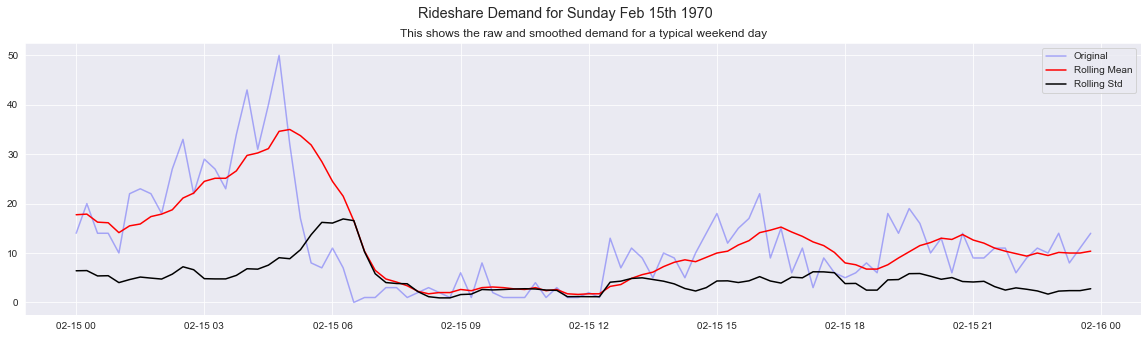

In [50]:
fig = plt.figure(figsize=(20,5))
# Resetting rolling mean & std to be 2-hours long
rolling_mean = q_hour.rolling(window=8).mean()
rolling_std = q_hour.rolling(window=8).std()
orig = plt.plot(q_hour.loc['1970-02-15'], color='blue',label='Original', alpha=0.3)
mean = plt.plot(rolling_mean.loc['1970-02-15'], color='red', label='Rolling Mean')
std = plt.plot(rolling_std.loc['1970-02-15'], color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.suptitle('Rideshare Demand for Sunday Feb 15th 1970', fontsize='x-large')
plt.title('This shows the raw and smoothed demand for a typical weekend day', fontsize='large');

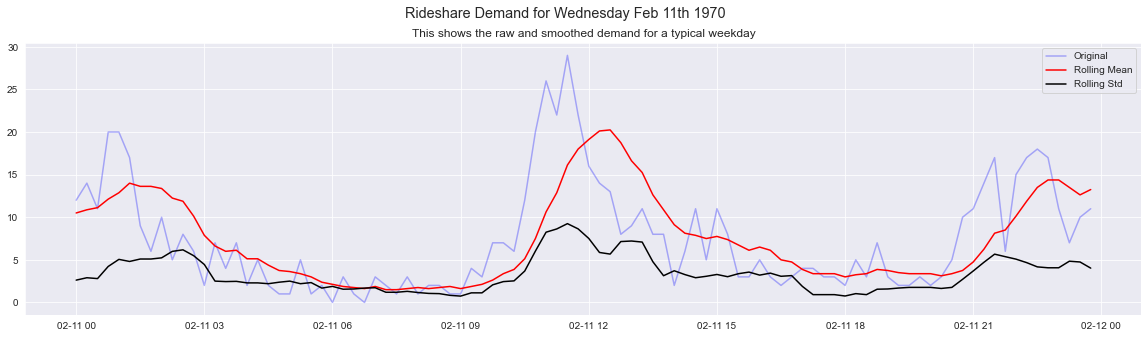

In [51]:
fig = plt.figure(figsize=(20,5))
orig = plt.plot(q_hour.loc['1970-02-11'], color='blue',label='Original', alpha=0.3)
mean = plt.plot(rolling_mean.loc['1970-02-11'], color='red', label='Rolling Mean')
std = plt.plot(rolling_std.loc['1970-02-11'], color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.suptitle('Rideshare Demand for Wednesday Feb 11th 1970', fontsize='x-large')
plt.title('This shows the raw and smoothed demand for a typical weekday', fontsize='large');

In [38]:
# Calculating the average demand for the beginning and end of the series to assess if there was any change over time
start = q_hour.loc['1970-02-05'].mean()[0]
end = q_hour.loc['1970-02-17'].mean()[0]
print('Starting demand for the app was ',  start, 
      ', while the finishing demand for the app was ', end)

Starting demand for the app was  7.166666666666667 , while the finishing demand for the app was  7.1875


#### Part 1 Conclusion:

1. While there is a SLIGHT upward trend (0.02 logins) in the average number of users over the time period being examined, there is no significant increase in demand over the course of this time series and it can be considered to have a stationary mean.

2. There is a weekly cycle that demonstrates a spike in activity that spikes on Saturdays and continues through Sundays.

3. There are two kinds of daily cycles.  The first occurs on weekends where there is a significant spike in the early hours of the morning, almost no activity throughout the morning, and above-average activity from noon onwards.  

4. The second kind of daily cycle occurs on most weekdays.  There is still a minor spike in activity in the wee hours of the morning, however there is a larger spike in activity from 11 AM - Noon, and and aditional spike in the late evening before midnight. 